In [1]:
# coding: utf-8
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 目标函数，需要用梯度下降求最小值
# 这里x0和x1的系数差距要大，这样才能产生震荡
func_f = lambda x: (x ** 2 * np.array([0.01, 1])).sum()
# 目标函数的梯度公式
func_g = lambda x: x * np.array([0.02, 2])

In [3]:
xx1 = np.linspace(-1, 1, 500)
xx2 = np.linspace(-0.5, 0.5, 500)
X1, X2 = np.meshgrid(xx1, xx2)
Y = np.apply_along_axis(func_f, 0, np.stack([X1, X2], axis=0))

In [4]:
def plot_contour(X1, X2, Y, steps=[]):
    plt.contour(X1, X2, Y)
    for i in range(1, len(steps)):
        a, b = steps[i]
        a_pre, b_pre = steps[i-1]
        plt.plot(np.array([a, a_pre]), np.array([b, b_pre]), 'o-')
    plt.show()

In [5]:
init_x = np.array([0.9, 0.5])

## SGD

SGD一直在垂直方向微小震荡，收敛很慢

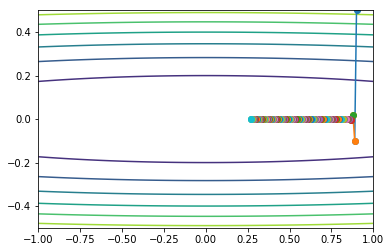

In [6]:
def SGD(init_x, epochs=100, lr=0.6):
    x = init_x.copy()
    steps = [x.copy()]
    for i in range(epochs):
        g = func_g(x)
        x -= lr * g
        steps.append(x.copy())
    return steps
plot_contour(X1, X2, Y, SGD(init_x))

## momentum

momentum收敛的速度比SGD快很多，不过会出现“跑过头”的情况

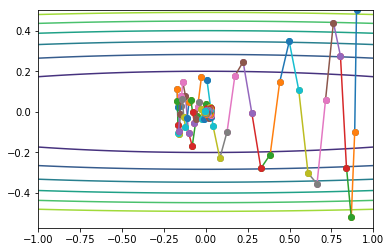

In [7]:
def momentum(init_x, epochs=100, lr=0.6, alpha=0.9):
    x = init_x.copy()
    steps = [x.copy()]
    v = np.zeros(x.shape)
    for i in range(epochs):
        g = func_g(x)
        v = alpha * v + lr * g
        x -= v
        steps.append(x.copy())
    return steps
plot_contour(X1, X2, Y, momentum(init_x))

## Nesterov accelerated gradient(NAG)

NAG相比于momentum会减轻“跑过头”的情况，但如果梯度一直是一个方向的（比如下图的水平方向），速度就会变慢

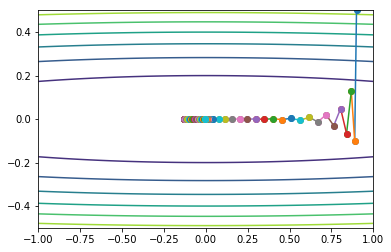

In [8]:
def NAG(init_x, epochs=100, lr=0.6, alpha=0.9):
    x = init_x.copy()
    steps = [x.copy()]
    v = np.zeros(x.shape)
    for i in range(epochs):
        v = alpha * v + lr * func_g(x - alpha * v)
        x -= v
        steps.append(x.copy())
    return steps
plot_contour(X1, X2, Y, NAG(init_x))

## Adagrad

In [25]:
def Adagrad(init_x, epochs=100, lr=0.1, epsilon=1e-8):
    x = init_x.copy()
    steps = [x.copy()]
    G = np.zeros(x.shape) # 历史梯度的平方和
    for i in range(epochs):
        g = func_g(x)
        G += g * g
        x -= lr * g / np.sqrt(G + epsilon)
        steps.append(x.copy())
    return steps

Adagrad对于狭长的谷适应性更强，不会再垂直方向震荡（不过学习率调太小会很慢，在实际中可能还好，因为实际情况特征一般都在0~1之前）

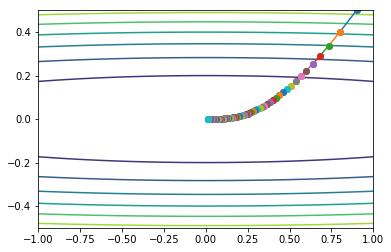

In [26]:
plot_contour(X1, X2, Y, Adagrad(init_x, lr=0.1))

Adagrad对应学习率也相对不是很敏感，将学习率调大10倍，刚开始会震荡，到仍然会收敛

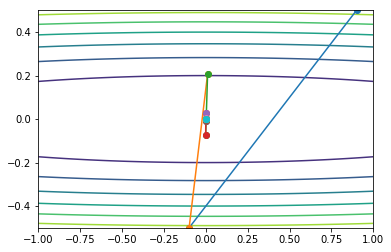

In [27]:
plot_contour(X1, X2, Y, Adagrad(init_x, lr=1))

## Adadelta

Adadelta虽然去掉了学习率，但是收敛速度跟epsilon有很大关系。从调学习率改成了调epsilon

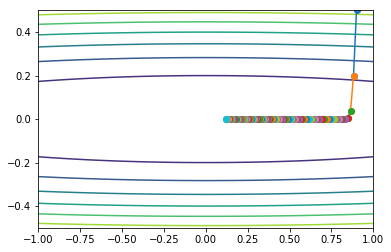

In [24]:
def Adadelta(init_x, epochs=100, gamma=0.9, epsilon=0.01):
    x = init_x.copy()
    steps = [x.copy()]
    G = np.zeros(x.shape) # E[g^2]
    DT = np.zeros(x.shape) # E[\Delta\theta^2]
    for i in range(epochs):
        g = func_g(x)
        G = gamma * G + (1 - gamma) * g * g
        dt = - np.sqrt(DT + epsilon) * g / np.sqrt(G + epsilon)
        DT = gamma * DT + (1 - gamma) * dt * dt
        x += dt
        steps.append(x.copy())
    return steps
plot_contour(X1, X2, Y, Adadelta(init_x))

## RMSprop

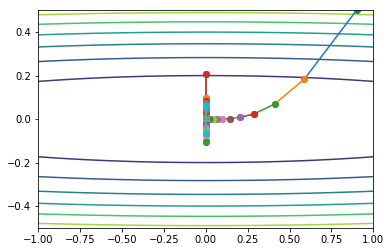

In [23]:
def RMSprop(init_x, epochs=100, lr=0.1, gamma=0.9, epsilon=1e-6):
    x = init_x.copy()
    steps = [x.copy()]
    G = np.zeros(x.shape) # E[g^2]
    for i in range(epochs):
        g = func_g(x)
        G = gamma * G + (1 - gamma) * g * g
        x -= lr * g / np.sqrt(G + epsilon)
        steps.append(x.copy())
    return steps
plot_contour(X1, X2, Y, RMSprop(init_x))

## Adam

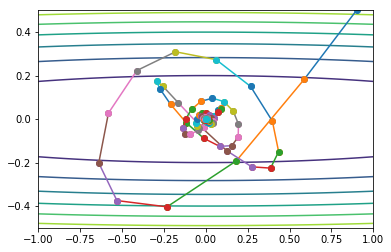

In [39]:
def Adam(init_x, epochs=100, lr=0.1, beta1=0.9, beta2=0.999, epsilon=1e-8):
    x = init_x.copy()
    steps = [x.copy()]
    v = np.zeros(x.shape)
    m = np.zeros(x.shape)
    beta1T = 1.0
    beta2T = 1.0
    for i in range(epochs):
        g = func_g(x)
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * g * g
        beta1T *= beta1
        beta2T *= beta2
        m_hat = m / beta1T
        v_hat = v / beta2T
        x -= lr * m / np.sqrt(v + epsilon)
        steps.append(x.copy())
    return steps
plot_contour(X1, X2, Y, Adam(init_x))